# **CLARA — MVSA-Multiple for Multimodal Sentiment (image + text) with CLIP+LoRA, DeBERTa+LoRA, Co-Attn, Verification+Uncertainty**


## **(0) Installing Library**

In [ ]:
# ============================== 0) SETUP ==============================
import sys, importlib
def _pip_quiet(pkgs):
    import subprocess
    for p in pkgs:
        try:
            importlib.import_module(p.split("[")[0].split("==")[0])
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

_pip_quiet([
    "transformers==4.42.4",
    "peft==0.11.1",
    "accelerate>=0.33.0",
    "scikit-learn",
    "plotly"
])

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
except Exception:
    print("⚠️  Not in Colab")

import os, random, warnings
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW

from transformers import (
    CLIPProcessor, CLIPVisionModel,
    DebertaV2Tokenizer, DebertaV2Model,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import plotly.graph_objects as go

warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted


## **(1) IMPORTS & CONFIG**

In [ ]:
CONFIG = {
    # Paths
    'text_dir': "/content/drive/MyDrive/MIT/DeCuong/MVSA/Dataset/MVSA_Multiple/data",
    'label_file': "/content/drive/MyDrive/MIT/DeCuong/MVSA/Dataset/MVSA_Multiple/labelResultAll.txt",

    # Models
    'vision_model_id': "openai/clip-vit-base-patch32",
    'text_model_id': "microsoft/deberta-v3-base",

    # Architecture
    'hidden_dim': 512,
    'num_classes': 3,
    'coattn_layers': 2,
    'coattn_heads': 8,
    'coattn_dropout': 0.1,

    # LoRA
    'enable_clip_lora': True,
    'lora_clip': {'r': 32, 'alpha': 64, 'dropout': 0.05},
    'lora_deb':  {'r': 64, 'alpha': 128, 'dropout': 0.10},

    # Training
    'batch_size': 48,
    'learning_rate': 5e-5,
    'weight_decay': 0.01,
    'max_epochs': 50,
    'early_stopping_patience': 12,
    'warmup_ratio': 0.16,
    'grad_accum_steps': 2,

    # Data
    'require_unanimous': True,     # 3/3 đồng thuận
    'require_cross_agree': True,   # text == image
    'use_soft_labels': False,
    'train_ratio': 0.7,
    'val_ratio': 0.15,

    # System
    'max_length': 128,
    'num_workers': 6,
    'pin_memory': True,
    'persistent_workers': True,
    'prefetch_factor': 2,
    'seed': 42,

    # Loss / Behavior (tối ưu Negative)
    'label_smoothing': 0.02,
    'consistency_weight': 0.10,
    'pred_veri_weight': 0.30,
    'feedback_tau': 0.5,

    'negative_class_boost': 12.0,     # sampler & class-weight boost
    'negative_focal_gamma': 4.0,      # focal gamma for Negative
    'negative_bias_posthoc': 0.6,     # simple post-hoc bias for Negative

    'min_ratio_negative': 0.30,       # enforce min Negative ratio in sampler

    # Mixup for Negative
    'use_mixup_negative': True,
    'mixup_alpha': 0.4,
}

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(CONFIG['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*70}\nCLARA TRAIN — MVSA-Multiple\n{'='*70}")
print("✅ Device:", device)
if torch.cuda.is_available():
    print("   GPU:", torch.cuda.get_device_name(0))

# TF32 + AMP
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_available() else torch.float32


CLARA TRAIN — MVSA-Multiple
✅ Device: cuda
   GPU: NVIDIA L4


## **(2) DATA LOADING — MVSA-Multiple**

In [ ]:

@dataclass
class MVSASample:
    image_path: str
    text_path: str
    image_id: str
    text_ann1: str; text_ann2: str; text_ann3: str
    image_ann1: str; image_ann2: str; image_ann3: str
    text_majority: str
    image_majority: str
    combined_majority: str
    text_unanimous: bool
    image_unanimous: bool

    @property
    def text(self):
        if not hasattr(self, '_text_cache'):
            try:
                with open(self.text_path, 'r', encoding='utf-8', errors='ignore') as f:
                    self._text_cache = f.read().strip()
            except Exception:
                self._text_cache = ""
        return self._text_cache

class MVSALoader:
    def __init__(self, text_dir: str, label_file: str):
        self.text_dir = Path(text_dir)
        self.label_file = Path(label_file)
        self.samples: List[MVSASample] = []

    @staticmethod
    def _check_unanimous(labels: List[str]) -> Tuple[str, bool]:
        return (labels[0], True) if len(set(labels)) == 1 else (labels[0], False)

    def load(self, require_unanimous=True, require_cross_agree=True):
        print("\n📂 LOADING with strict filters:",
              f"Unanimous={require_unanimous}, Cross-agree={require_cross_agree}")
        buf = {}
        with open(self.label_file, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        for line in lines[1:]:
            p = line.strip().split('\t')
            if len(p) < 4:
                continue
            img_id = p[0].strip()
            try:
                t1, i1 = [x.strip().lower() for x in p[1].split(',')]
                t2, i2 = [x.strip().lower() for x in p[2].split(',')]
                t3, i3 = [x.strip().lower() for x in p[3].split(',')]
            except Exception:
                continue
            t_lab, t_uni = self._check_unanimous([t1, t2, t3])
            i_lab, i_uni = self._check_unanimous([i1, i2, i3])
            if require_unanimous and (not t_uni or not i_uni):
                continue
            if require_cross_agree and (t_lab != i_lab):
                continue
            buf[img_id] = dict(
                text_ann1=t1, text_ann2=t2, text_ann3=t3,
                image_ann1=i1, image_ann2=i2, image_ann3=i3,
                text_majority=t_lab, image_majority=i_lab, combined_majority=t_lab,
                text_unanimous=t_uni, image_unanimous=i_uni
            )

        txt_files = {f.stem: f for f in self.text_dir.glob('*.txt')}
        img_exts = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
        self.samples = []
        for img_id, info in buf.items():
            if img_id not in txt_files:
                continue
            ip = None
            for e in img_exts:
                c = self.text_dir / f"{img_id}{e}"
                if c.exists():
                    ip = c
                    break
            if ip is None:
                continue
            self.samples.append(MVSASample(
                image_path=str(ip), text_path=str(txt_files[img_id]),
                image_id=img_id, **info
            ))

        cnt = Counter([s.combined_majority for s in self.samples])
        n = len(self.samples)
        print(f"   ✓ Loaded: {n}")
        if n > 0:
            for lab in ['positive', 'neutral', 'negative']:
                c = cnt.get(lab, 0)
                print(f"   - {lab.capitalize():8s}: {c:4d} ({c/max(1,n)*100:5.1f}%)")
        return self.samples

    def split(self, train_ratio=0.7, val_ratio=0.15, seed=42):
        random.seed(seed)
        groups = {'positive': [], 'neutral': [], 'negative': []}
        for s in self.samples:
            groups[s.combined_majority].append(s)
        train, val, test = [], [], []
        for arr in groups.values():
            random.shuffle(arr)
            n = len(arr)
            n_tr = int(n * train_ratio)
            n_va = int(n * val_ratio)
            train.extend(arr[:n_tr])
            val.extend(arr[n_tr:n_tr+n_va])
            test.extend(arr[n_tr+n_va:])
        random.shuffle(train); random.shuffle(val); random.shuffle(test)
        return train, val, test

loader = MVSALoader(CONFIG['text_dir'], CONFIG['label_file'])
all_samples = loader.load(CONFIG['require_unanimous'], CONFIG['require_cross_agree'])
if len(all_samples) == 0:
    raise ValueError("❌ Empty dataset. Relax filters.")

train_samples, val_samples, test_samples = loader.split(
    CONFIG['train_ratio'], CONFIG['val_ratio'], CONFIG['seed']
)

print("\n" + "="*70 + "\nSPLIT\n" + "="*70)
for name, arr in [("Train", train_samples), ("Val", val_samples), ("Test", test_samples)]:
    c = Counter([s.combined_majority for s in arr])
    print(
        f"   {name:5s}: {len(arr):4d} | "
        f"Pos:{c.get('positive',0):4d} Neu:{c.get('neutral',0):4d} Neg:{c.get('negative',0):4d}"
    )


📂 LOADING with strict filters: Unanimous=True, Cross-agree=True
   ✓ Loaded: 3555
   - Positive: 2173 ( 61.1%)
   - Neutral : 1268 ( 35.7%)
   - Negative:  114 (  3.2%)

SPLIT
   Train: 2487 | Pos:1521 Neu: 887 Neg:  79
   Val  :  532 | Pos: 325 Neu: 190 Neg:  17
   Test :  536 | Pos: 327 Neu: 191 Neg:  18


## **(3) DATASET & DATALOADER**

In [ ]:
clip_processor = CLIPProcessor.from_pretrained(CONFIG['vision_model_id'])
tokenizer      = DebertaV2Tokenizer.from_pretrained(CONFIG['text_model_id'])
print("\n✅ Processors ready")

class MVSADataset(Dataset):
    def __init__(self, samples, use_mixup=False, mixup_alpha=0.4):
        self.samples = samples
        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha
        self.map = {'positive': 0, 'neutral': 1, 'negative': 2}
        self.neg_idx = [i for i, s in enumerate(samples) if s.combined_majority == 'negative']

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        try:
            img = Image.open(s.image_path).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224, 224), (0, 0, 0))
        text = s.text
        label = self.map[s.combined_majority]
        # Mixup for Negative
        if self.use_mixup and s.combined_majority == 'negative' and len(self.neg_idx) > 1 and random.random() < 0.5:
            other_idx = random.choice([i for i in self.neg_idx if i != idx])
            try:
                img2 = Image.open(self.samples[other_idx].image_path).convert('RGB')
                lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                arr = (np.array(img) * lam + np.array(img2) * (1-lam)).astype(np.uint8)
                img = Image.fromarray(arr)
            except Exception:
                pass
        return {'image': img, 'text': text, 'label': label}

def collate_fn(batch):
    images = [b['image'] for b in batch]
    pv = clip_processor(images=images, return_tensors='pt')['pixel_values']
    texts = [b['text'] for b in batch]
    enc = tokenizer(
        texts, max_length=CONFIG['max_length'],
        padding=True, truncation=True, return_tensors='pt'
    )
    labels = torch.tensor([b['label'] for b in batch], dtype=torch.long)
    return {
        'pixel_values': pv,
        'input_ids': enc['input_ids'],
        'attention_mask': enc['attention_mask'],
        'labels': labels
    }

def build_extreme_negative_sampler(samples, neg_boost=12.0, min_ratio_neg=0.30):
    if len(samples) == 0:
        return None, True
    labs = [s.combined_majority for s in samples]
    cnt = Counter(labs)
    if not cnt:
        return None, True
    total = sum(cnt.values())
    k = len(cnt)
    weights = {}
    for lab, c in cnt.items():
        base = total / (k * c)
        weights[lab] = base * (neg_boost if lab == 'negative' else 1.0)
    # Enforce min Negative ratio
    cur_ratio = cnt.get('negative', 0) / max(1, total)
    if cur_ratio < min_ratio_neg and cnt.get('negative', 0) > 0:
        scale = min_ratio_neg / max(1e-8, cur_ratio)
        weights['negative'] *= scale
        print(f"Negative min-ratio boost x{scale:.2f} → target {min_ratio_neg*100:.1f}%")
    sw = torch.tensor(
        [float(weights.get(s.combined_majority, 1.0)) for s in samples],
        dtype=torch.double
    )
    if sw.numel() == 0 or not torch.isfinite(sw).all():
        return None, True
    return WeightedRandomSampler(sw, num_samples=sw.numel(), replacement=True), False

train_ds = MVSADataset(
    train_samples,
    use_mixup=CONFIG['use_mixup_negative'],
    mixup_alpha=CONFIG['mixup_alpha']
)
val_ds   = MVSADataset(val_samples,  use_mixup=False)
test_ds  = MVSADataset(test_samples, use_mixup=False)

sampler, use_shuffle = build_extreme_negative_sampler(
    train_samples,
    CONFIG['negative_class_boost'],
    CONFIG['min_ratio_negative']
)

train_loader = DataLoader(
    train_ds, batch_size=CONFIG['batch_size'],
    sampler=None if use_shuffle else sampler,
    shuffle=use_shuffle,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds, batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory'],
    persistent_workers=CONFIG['persistent_workers'],
    prefetch_factor=CONFIG['prefetch_factor'],
    collate_fn=collate_fn
)

print(f"\n✅ DataLoaders: Train={len(train_loader)} | Val={len(val_loader)} | Test={len(test_loader)}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]


✅ Processors ready
Negative min-ratio boost x9.44 → target 30.0%

✅ DataLoaders: Train=52 | Val=12 | Test=12


## **(4) MODEL CLARA & ADAPTER**

In [ ]:
class CoAttentionFusion(nn.Module):
    def __init__(self, vision_dim=768, text_dim=768, hidden_dim=512,
                 num_layers=2, num_heads=8, dropout=0.1):
        super().__init__()
        self.v_proj = nn.Linear(vision_dim, hidden_dim)
        self.t_proj = nn.Linear(text_dim, hidden_dim)
        self.cross = nn.ModuleList([
            nn.MultiheadAttention(
                hidden_dim, num_heads, dropout=dropout, batch_first=True
            )
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        self.fuse = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, v_feat, t_feat):
        v = self.v_proj(v_feat).unsqueeze(1)
        t = self.t_proj(t_feat).unsqueeze(1)
        for i, attn in enumerate(self.cross):
            t_attn, _ = attn(t, v, v)
            t = self.norms[i*2](t + t_attn)
            v_attn, _ = attn(v, t, t)
            v = self.norms[i*2+1](v + v_attn)
        fused = torch.cat([v.squeeze(1), t.squeeze(1)], dim=-1)
        return self.fuse(fused)

class CLARAModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.h = config['hidden_dim']
        self.C = config['num_classes']
        self.tau = config['feedback_tau']

        # Vision + LoRA → VisionOnly wrapper
        _vision = CLIPVisionModel.from_pretrained(config['vision_model_id'])
        if config['enable_clip_lora']:
            lcfg = LoraConfig(
                r=config['lora_clip']['r'],
                lora_alpha=config['lora_clip']['alpha'],
                lora_dropout=config['lora_clip']['dropout'],
                target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
                task_type=TaskType.FEATURE_EXTRACTION
            )
            _vision = get_peft_model(_vision, lcfg)
        base = _vision
        # Unwrap if there are wrapper modules
        for _ in range(5):
            progressed = False
            for attr in ("get_base_model", "base_model", "model", "module"):
                if hasattr(base, attr):
                    obj = getattr(base, attr)
                    try:
                        base = obj() if callable(obj) else obj
                        progressed = True
                        break
                    except Exception:
                        pass
            if not progressed:
                break

        class VisionOnly(nn.Module):
            def __init__(self, b):
                super().__init__(); self.b = b
            def forward(self, *, pixel_values):
                return self.b.forward(pixel_values=pixel_values)

        self.vision = VisionOnly(base)
        self.vision_core = base  # for freeze/unfreeze

        # Text + LoRA
        deb = DebertaV2Model.from_pretrained(config['text_model_id'])
        lcfgd = LoraConfig(
            r=config['lora_deb']['r'],
            lora_alpha=config['lora_deb']['alpha'],
            lora_dropout=config['lora_deb']['dropout'],
            target_modules=["query_proj", "key_proj", "value_proj"],
            task_type=TaskType.FEATURE_EXTRACTION
        )
        self.text = get_peft_model(deb, lcfgd)

        v_dim = getattr(self.vision_core.config, 'hidden_size', 768)
        t_dim = self.text.config.hidden_size
        self.fusion = CoAttentionFusion(
            v_dim, t_dim, config['hidden_dim'],
            config['coattn_layers'], config['coattn_heads'],
            config['coattn_dropout']
        )

        self.pred = nn.Sequential(
            nn.Linear(self.h, self.h//2),
            nn.LayerNorm(self.h//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self.h//2, self.C)
        )
        self.veri = nn.Sequential(
            nn.Linear(self.h, self.h//2),
            nn.LayerNorm(self.h//2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(self.h//2, self.C)
        )
        self.feed = nn.Sequential(
            nn.Linear(self.h + self.C, self.h),
            nn.LayerNorm(self.h),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.final = nn.Linear(self.h, self.C)

    # keyword-only to avoid CLIP arg mismatch
    def forward(self, *, pixel_values, input_ids, attention_mask):
        v_out = self.vision(pixel_values=pixel_values)
        v_feat = v_out.last_hidden_state.mean(dim=1)

        t_out = self.text(input_ids=input_ids, attention_mask=attention_mask)
        t_seq = t_out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

        fused = self.fusion(v_feat, t_feat)
        lg_p = self.pred(fused)
        lg_v = self.veri(fused)

        p_v = F.softmax(lg_v / self.tau, dim=-1).detach()
        p_p = F.softmax(lg_p / self.tau, dim=-1).detach()

        ref = self.feed(torch.cat([fused, (p_v - p_p)], dim=-1))
        lg_f = self.final(ref)
        return lg_f, lg_p, lg_v

print("\n Initializing CLARA…")
model = CLARAModel(CONFIG).to(device)
tot = sum(p.numel() for p in model.parameters())
trn = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Params: {trn:,}/{tot:,} ({trn/tot*100:.2f}%)")


 Initializing CLARA…


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

 Params: 9,848,841/281,136,393 (3.50%)


## **(5) LOSS & OPTIMIZER**

In [ ]:

train_labels = [s.combined_majority for s in train_samples]
cc = Counter(train_labels)
ce_w = torch.tensor([
    float(cc.get('positive', 1)),
    float(cc.get('neutral', 1)),
    float(cc.get('negative', 1)) * CONFIG['negative_class_boost']
], dtype=torch.float, device=device)
ce_w = (ce_w.sum() / (3.0 * ce_w)).clamp_min(1e-8)
print("\n Class Weights (boosted Negative):",
      f"Pos={float(ce_w[0]):.3f} Neu={float(ce_w[1]):.3f} Neg={float(ce_w[2]):.3f}")

class ExtremeFocalLoss(nn.Module):
    def __init__(self, gamma_map={0:1.0, 1:2.0, 2:4.0}, weight=None, eps=0.02):
        super().__init__()
        self.gamma_map = gamma_map
        self.weight = weight
        self.eps = eps

    def forward(self, logits, target):
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            smooth = torch.full_like(logp, self.eps/(n-1))
            smooth.scatter_(1, target.unsqueeze(1), 1.0 - self.eps)
        p = F.softmax(logits, dim=-1).clamp_min(1e-8)
        pt = p.gather(1, target.unsqueeze(1)).squeeze(1)
        gamma = torch.tensor(
            [self.gamma_map.get(int(t.item()), 1.0) for t in target],
            device=logits.device, dtype=logits.dtype
        )
        focal = (1-pt)**gamma
        loss = -(smooth * logp).sum(dim=1)
        loss = focal * loss
        if self.weight is not None:
            w = self.weight[target]
            loss = loss * w
        return loss.mean()

criterion = ExtremeFocalLoss(
    gamma_map={0:1.0, 1:2.0, 2:CONFIG['negative_focal_gamma']},
    weight=ce_w,
    eps=CONFIG['label_smoothing']
)

optimizer = AdamW(model.parameters(),
                  lr=CONFIG['learning_rate'],
                  weight_decay=CONFIG['weight_decay'])
total_steps = max(1, (len(train_loader)*CONFIG['max_epochs']) // max(1, CONFIG['grad_accum_steps']))
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

def set_trainable_except_lora(module, flag: bool):
    for n, p in module.named_parameters():
        if 'lora_' in n:
            p.requires_grad = True
        else:
            p.requires_grad = flag

# Freeze encoders (only LoRA trainable)
set_trainable_except_lora(model.text, False)
set_trainable_except_lora(model.vision_core, False)
print("🔒 Encoders frozen (LoRA trainable only)")


 Class Weights (boosted Negative): Pos=0.735 Neu=1.261 Neg=1.180
🔒 Encoders frozen (LoRA trainable only)


## **(6) TRAIN / EVAL FUNCTIONS**

In [ ]:
# ============================== 6) TRAIN / EVAL FUNCTIONS ==============================
def train_epoch(model, loader, optimizer, scheduler, device, epoch):
    model.train()
    total = 0.0
    accum = max(1, CONFIG['grad_accum_steps'])
    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for step, b in enumerate(pbar, start=1):
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)

        with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
            lg_f, lg_p, lg_v = model(
                pixel_values=pv,
                input_ids=ids,
                attention_mask=att
            )
            loss_f = criterion(lg_f, lab)
            loss_p = criterion(lg_p, lab)
            loss_v = criterion(lg_v, lab)
            # Consistency between Prediction & Verification
            pp = F.softmax(lg_p, dim=-1)
            pv_ = F.softmax(lg_v, dim=-1)
            kl1 = F.kl_div((pp+1e-8).log(), pv_, reduction='batchmean')
            kl2 = F.kl_div((pv_+1e-8).log(), pp, reduction='batchmean')
            cons = kl1 + kl2

            loss = loss_f + CONFIG['pred_veri_weight']*(loss_p+loss_v) + CONFIG['consistency_weight']*cons
            loss = loss / accum

        loss.backward()
        if step % accum == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        total += float(loss.detach().cpu())
        pbar.set_postfix({'loss': f"{loss.item()*accum:.4f}"})
    return total / max(1, len(loader))

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    P, Y = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)
        with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
            lg_f, _, _ = model(
                pixel_values=pv,
                input_ids=ids,
                attention_mask=att
            )
            preds = lg_f.argmax(dim=-1)
        P.extend(preds.cpu().tolist())
        Y.extend(lab.cpu().tolist())
    acc  = accuracy_score(Y, P)
    f1_m = f1_score(Y, P, average='macro')
    f1_w = f1_score(Y, P, average='weighted')
    return acc, f1_m, f1_w, P, Y

## **(7) TRAIN LOOP**

In [ ]:
# ============================== 7) TRAIN LOOP ==============================
print("\n" + "="*70 + "\nTRAINING\n" + "="*70)
best_f1 = 0.0
pat = 0

for epoch in range(1, CONFIG['max_epochs']+1):
    # optional: unfreeze encoders after a few epochs
    if epoch == 3:
        set_trainable_except_lora(model.text, True)
        set_trainable_except_lora(model.vision_core, True)
        print("Encoders unfrozen")

    tr_loss = train_epoch(model, train_loader, optimizer, scheduler, device, epoch)
    va_acc, va_f1m, va_f1w, _, _ = evaluate(model, val_loader, device)
    print(f"\n Epoch {epoch}/{CONFIG['max_epochs']}")
    print(f"   Loss: {tr_loss:.4f} | Acc: {va_acc:.4f} | F1-Macro: {va_f1m:.4f} | F1-Weighted: {va_f1w:.4f}")

    # Early stopping by F1-Macro (giống bản bạn đang dùng)
    if va_f1m > best_f1:
        best_f1 = va_f1m
        pat = 0
        torch.save(model.state_dict(), "best_clara.pt")
        print(f"   ✅ New best! (F1-Macro={best_f1:.4f})")
    else:
        pat += 1
        if pat >= CONFIG['early_stopping_patience']:
            print("🛑 Early stopping")
            break


TRAINING


Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


 Epoch 1/50
   Loss: 0.2441 | Acc: 0.0320 | F1-Macro: 0.0206 | F1-Weighted: 0.0020
   ✅ New best! (F1-Macro=0.0206)



 Epoch 2/50
   Loss: 0.0336 | Acc: 0.0320 | F1-Macro: 0.0206 | F1-Weighted: 0.0020
Encoders unfrozen



 Epoch 3/50
   Loss: 0.0217 | Acc: 0.0320 | F1-Macro: 0.0206 | F1-Weighted: 0.0020



 Epoch 4/50
   Loss: 0.0174 | Acc: 0.3759 | F1-Macro: 0.3285 | F1-Weighted: 0.3698
   ✅ New best! (F1-Macro=0.3285)



 Epoch 5/50
   Loss: 0.0082 | Acc: 0.3139 | F1-Macro: 0.2590 | F1-Weighted: 0.1883



 Epoch 6/50
   Loss: 0.0090 | Acc: 0.5320 | F1-Macro: 0.4842 | F1-Weighted: 0.5434
   ✅ New best! (F1-Macro=0.4842)



 Epoch 7/50
   Loss: 0.0085 | Acc: 0.4812 | F1-Macro: 0.3271 | F1-Weighted: 0.4737



 Epoch 8/50
   Loss: 0.0130 | Acc: 0.5921 | F1-Macro: 0.3819 | F1-Weighted: 0.5206



 Epoch 9/50
   Loss: 0.0096 | Acc: 0.2274 | F1-Macro: 0.1812 | F1-Weighted: 0.1443



 Epoch 10/50
   Loss: 0.0168 | Acc: 0.4380 | F1-Macro: 0.3348 | F1-Weighted: 0.4771



 Epoch 11/50
   Loss: 0.0111 | Acc: 0.6241 | F1-Macro: 0.3855 | F1-Weighted: 0.5075



 Epoch 12/50
   Loss: 0.0075 | Acc: 0.3327 | F1-Macro: 0.2821 | F1-Weighted: 0.1861



 Epoch 13/50
   Loss: 0.0059 | Acc: 0.6184 | F1-Macro: 0.4289 | F1-Weighted: 0.5399



 Epoch 14/50
   Loss: 0.0043 | Acc: 0.6410 | F1-Macro: 0.4834 | F1-Weighted: 0.5776



 Epoch 15/50
   Loss: 0.0046 | Acc: 0.4925 | F1-Macro: 0.4352 | F1-Weighted: 0.5016



 Epoch 16/50
   Loss: 0.0080 | Acc: 0.4398 | F1-Macro: 0.4022 | F1-Weighted: 0.3857



 Epoch 17/50
   Loss: 0.0065 | Acc: 0.7199 | F1-Macro: 0.5698 | F1-Weighted: 0.7025
   ✅ New best! (F1-Macro=0.5698)



 Epoch 18/50
   Loss: 0.0053 | Acc: 0.6165 | F1-Macro: 0.5350 | F1-Weighted: 0.6276



 Epoch 19/50
   Loss: 0.0044 | Acc: 0.7237 | F1-Macro: 0.5498 | F1-Weighted: 0.6923



 Epoch 20/50
   Loss: 0.0035 | Acc: 0.6748 | F1-Macro: 0.5548 | F1-Weighted: 0.6957



 Epoch 21/50
   Loss: 0.0047 | Acc: 0.7162 | F1-Macro: 0.5770 | F1-Weighted: 0.7164
   ✅ New best! (F1-Macro=0.5770)



 Epoch 22/50
   Loss: 0.0046 | Acc: 0.5996 | F1-Macro: 0.5156 | F1-Weighted: 0.6089



 Epoch 23/50
   Loss: 0.0034 | Acc: 0.7180 | F1-Macro: 0.5984 | F1-Weighted: 0.7230
   ✅ New best! (F1-Macro=0.5984)



 Epoch 24/50
   Loss: 0.0045 | Acc: 0.7068 | F1-Macro: 0.5571 | F1-Weighted: 0.6838



 Epoch 25/50
   Loss: 0.0049 | Acc: 0.7406 | F1-Macro: 0.6007 | F1-Weighted: 0.7390
   ✅ New best! (F1-Macro=0.6007)



 Epoch 26/50
   Loss: 0.0035 | Acc: 0.4831 | F1-Macro: 0.4010 | F1-Weighted: 0.4372



 Epoch 27/50
   Loss: 0.0052 | Acc: 0.7425 | F1-Macro: 0.5920 | F1-Weighted: 0.7425



 Epoch 28/50
   Loss: 0.0032 | Acc: 0.7406 | F1-Macro: 0.5853 | F1-Weighted: 0.7284



 Epoch 29/50
   Loss: 0.0037 | Acc: 0.7162 | F1-Macro: 0.5866 | F1-Weighted: 0.7235



 Epoch 30/50
   Loss: 0.0074 | Acc: 0.7293 | F1-Macro: 0.5773 | F1-Weighted: 0.7156



 Epoch 31/50
   Loss: 0.0059 | Acc: 0.7237 | F1-Macro: 0.5759 | F1-Weighted: 0.7202



 Epoch 32/50
   Loss: 0.0035 | Acc: 0.6259 | F1-Macro: 0.5318 | F1-Weighted: 0.6370



 Epoch 33/50
   Loss: 0.0028 | Acc: 0.7274 | F1-Macro: 0.6074 | F1-Weighted: 0.7326
   ✅ New best! (F1-Macro=0.6074)



 Epoch 34/50
   Loss: 0.0042 | Acc: 0.7538 | F1-Macro: 0.6207 | F1-Weighted: 0.7526
   ✅ New best! (F1-Macro=0.6207)



 Epoch 35/50
   Loss: 0.0031 | Acc: 0.6673 | F1-Macro: 0.5717 | F1-Weighted: 0.6735



 Epoch 36/50
   Loss: 0.0027 | Acc: 0.7425 | F1-Macro: 0.6003 | F1-Weighted: 0.7439



 Epoch 37/50
   Loss: 0.0047 | Acc: 0.7368 | F1-Macro: 0.5510 | F1-Weighted: 0.7240



 Epoch 38/50
   Loss: 0.0031 | Acc: 0.7124 | F1-Macro: 0.5793 | F1-Weighted: 0.7186



 Epoch 39/50
   Loss: 0.0029 | Acc: 0.6880 | F1-Macro: 0.5644 | F1-Weighted: 0.6950



 Epoch 40/50
   Loss: 0.0023 | Acc: 0.7162 | F1-Macro: 0.5782 | F1-Weighted: 0.7203



 Epoch 41/50
   Loss: 0.0033 | Acc: 0.7049 | F1-Macro: 0.5732 | F1-Weighted: 0.7109



 Epoch 42/50
   Loss: 0.0031 | Acc: 0.7500 | F1-Macro: 0.5918 | F1-Weighted: 0.7403



 Epoch 43/50
   Loss: 0.0031 | Acc: 0.7293 | F1-Macro: 0.5870 | F1-Weighted: 0.7307



 Epoch 44/50
   Loss: 0.0039 | Acc: 0.6447 | F1-Macro: 0.5259 | F1-Weighted: 0.6485



 Epoch 45/50
   Loss: 0.0026 | Acc: 0.7124 | F1-Macro: 0.5658 | F1-Weighted: 0.7169



 Epoch 46/50
   Loss: 0.0032 | Acc: 0.7068 | F1-Macro: 0.5628 | F1-Weighted: 0.7118
🛑 Early stopping


## **(8) FINAL EVAL + SIMPLE NEGATIVE BIAS**

In [ ]:

print("\n" + "="*70 + "\nFINAL EVALUATION (RAW + SIMPLE NEG BIAS)\n" + "="*70)
if os.path.exists("best_clara.pt"):
    model.load_state_dict(torch.load("best_clara.pt", map_location=device))

te_acc, te_f1m, te_f1w, te_P, te_Y = evaluate(model, test_loader, device)
print(f"\n🎯 RAW TEST RESULTS:")
print(f"   Accuracy   : {te_acc:.4f}")
print(f"   F1-Macro   : {te_f1m:.4f}")
print(f"   F1-Weighted: {te_f1w:.4f}")
print("\n📊 Raw Classification Report:")
print(classification_report(te_Y, te_P, target_names=['Positive','Neutral','Negative']))


@torch.no_grad()
def evaluate_posthoc_bias(model, loader, device, neg_bias=0.6):
    model.eval()
    P, Y = [], []
    bias = torch.tensor([0.0, 0.0, float(neg_bias)], device=device)
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)
        lg_f, _, _ = model(pixel_values=pv, input_ids=ids, attention_mask=att)
        preds = (lg_f + bias.view(1, -1)).argmax(dim=-1)
        P.extend(preds.cpu().tolist())
        Y.extend(lab.cpu().tolist())
    acc  = accuracy_score(Y, P)
    f1_m = f1_score(Y, P, average='macro')
    f1_w = f1_score(Y, P, average='weighted')
    return acc, f1_m, f1_w, P, Y

ph_acc, ph_f1m, ph_f1w, ph_P, ph_Y = evaluate_posthoc_bias(
    model, test_loader, device, neg_bias=CONFIG['negative_bias_posthoc']
)
print(f"\n🎯 POST-HOC TEST RESULTS (simple Neg bias={CONFIG['negative_bias_posthoc']}):")
print(f"   Accuracy   : {ph_acc:.4f}")
print(f"   F1-Macro   : {ph_f1m:.4f}")
print(f"   F1-Weighted: {ph_f1w:.4f}")
print("\n📊 Post-hoc Classification Report:")
print(classification_report(ph_Y, ph_P, target_names=['Positive','Neutral','Negative']))



FINAL EVALUATION (RAW + SIMPLE NEG BIAS)



🎯 RAW TEST RESULTS:
   Accuracy   : 0.7369
   F1-Macro   : 0.6619
   F1-Weighted: 0.7362

📊 Raw Classification Report:
              precision    recall  f1-score   support

    Positive       0.80      0.81      0.81       327
     Neutral       0.63      0.63      0.63       191
    Negative       0.60      0.50      0.55        18

    accuracy                           0.74       536
   macro avg       0.68      0.65      0.66       536
weighted avg       0.74      0.74      0.74       536


🎯 POST-HOC TEST RESULTS (simple Neg bias=0.6):
   Accuracy   : 0.7313
   F1-Macro   : 0.6479
   F1-Weighted: 0.7309

📊 Post-hoc Classification Report:
              precision    recall  f1-score   support

    Positive       0.80      0.81      0.80       327
     Neutral       0.63      0.62      0.62       191
    Negative       0.53      0.50      0.51        18

    accuracy                           0.73       536
   macro avg       0.65      0.64      0.65       536
weighted avg       0.

In [ ]:
def plot_confusion_matrix(
    y_true,
    y_pred,
    labels=None,
    title="Confusion Matrix"
):
    """
    Vẽ confusion matrix bằng plotly (heatmap).
    - Hiển thị số lượng trong từng ô.
    - Trục x = Predicted, trục y = True.
    """
    if labels is None:
        # nếu không truyền, dùng nhãn số
        labels = [str(i) for i in sorted(np.unique(y_true))]

    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    fig = go.Figure(
        data=go.Heatmap(
            z=cm,
            x=labels,
            y=labels,
            text=cm,
            texttemplate="%{text}",
            colorscale="Blues",
            hovertemplate="True: %{y}<br>Pred: %{x}<br>Count=%{z}<extra></extra>",
        )
    )

    fig.update_layout(
        title=title,
        xaxis_title="Predicted label",
        yaxis_title="True label",
        yaxis_autorange="reversed",  # true label 0 ở trên cùng
        template="plotly_white",
        width=600,
        height=500,
    )

    fig.show()
    return cm


cm_raw = plot_confusion_matrix(
    te_Y, te_P,
    labels=["Positive", "Neutral", "Negative"],
    title="CLARA – Raw Confusion Matrix (TEST)"
)


cm_posthoc = plot_confusion_matrix(
    ph_Y, ph_P,
    labels=["Positive", "Neutral", "Negative"],
    title="CLARA – Post-hoc Confusion Matrix (TEST)"
)


## **(9) CONFIDENCE ANALYSIS, VARIANT COMPARISON & ABLATION STUDY**

In [ ]:
# ==============================  GATHER LOGITS ON VAL & TEST ==============================
@torch.no_grad()
def gather_logits_labels(model, loader, device):
    """
    Gather FINAL logits (lg_f) & labels from loader.
    FIX: convert BF16 → FP32 before calling .numpy()
    """
    model.eval()
    LG, Y = [], []
    for b in tqdm(loader, desc="Gathering logits", leave=False):
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        att = b['attention_mask'].to(device, non_blocking=True)
        lab = b['labels'].long().to(device, non_blocking=True)
        with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
            lg_f, _, _ = model(pixel_values=pv, input_ids=ids, attention_mask=att)
        LG.append(lg_f.detach().cpu())
        Y.append(lab.detach().cpu())
    # 🔧 FIX: convert to float32 before .numpy() to avoid BF16 error
    LG = torch.cat(LG, 0).to(torch.float32).numpy()
    Y  = torch.cat(Y, 0).numpy()
    return LG, Y

print("\n" + "="*70 + "\nCALIBRATION & CONFIDENCE ANALYSIS (VAL→TEST)\n" + "="*70)
logits_val, y_val_np   = gather_logits_labels(model, val_loader, device)
logits_test, y_test_np = gather_logits_labels(model, test_loader, device)

# ==============================  TUNE BIAS+TEMP FOR NEUTRAL (VAL) ==============================
def apply_bias_temp_neutral(logits, b_neu=0.0, tau_neu=1.0):
    """
    Bias+Temperature for Neutral (class 1):
      - logits[:,1] = logits[:,1] / tau_neu + b_neu
    """
    lg = logits.copy()
    scale = np.ones(3, dtype=np.float32)
    scale[1] = 1.0 / max(1e-6, float(tau_neu))
    lg = lg * scale[None, :]
    lg[:, 1] += float(b_neu)
    return lg

def tune_bias_temp_neutral(logits_val, y_val,
                            b_grid=None,
                            tau_grid=None):
    """
    Grid-search (b_neu, tau_neu) on VAL to maximize Macro-F1.
    """
    if b_grid is None:
        b_grid = np.linspace(-1.0, 1.0, 9)
    if tau_grid is None:
        tau_grid = np.linspace(0.7, 1.5, 9)

    best_f1m = -1.0
    best_cfg = (0.0, 1.0)

    for b_neu in b_grid:
        for tau_neu in tau_grid:
            lg_adj = apply_bias_temp_neutral(logits_val, b_neu=b_neu, tau_neu=tau_neu)
            preds = lg_adj.argmax(axis=1)
            f1_m  = f1_score(y_val, preds, average='macro')
            if f1_m > best_f1m:
                best_f1m = f1_m
                best_cfg = (b_neu, tau_neu)
    return best_f1m, best_cfg

print("🔍 Tuning Bias+Temp for Neutral on VAL (macro-F1)...")
best_f1m_val_bt, (b_opt, tau_opt) = tune_bias_temp_neutral(logits_val, y_val_np)
print(f"   → Best VAL Macro-F1 (Bias+Temp) = {best_f1m_val_bt:.4f}")
print(f"     b_opt (Neutral bias) = {b_opt:.3f}")
print(f"     tau_opt (Neutral temperature) = {tau_opt:.3f}")


# ============================== TUNE AFFINE NEUTRAL (VAL) ==============================
def apply_affine_neutral(logits, w_neu=1.0, b_neu=0.0):
    """
    Affine transform for Neutral (class 1):
      logits[:,1] = w_neu * logits[:,1] + b_neu
    """
    lg = logits.copy()
    lg[:, 1] = float(w_neu) * lg[:, 1] + float(b_neu)
    return lg

def tune_affine_neutral(logits_val, y_val,
                        w_grid=None,
                        b_grid=None):
    """
    Grid-search (w_neu, b_neu) on VAL to maximize Macro-F1.
    """
    if w_grid is None:
        w_grid = np.linspace(0.5, 1.5, 9)
    if b_grid is None:
        b_grid = np.linspace(-1.0, 1.0, 9)

    best_f1m = -1.0
    best_cfg = (1.0, 0.0)

    for w_neu in w_grid:
        for b_neu in b_grid:
            lg_adj = apply_affine_neutral(logits_val, w_neu=w_neu, b_neu=b_neu)
            preds = lg_adj.argmax(axis=1)
            f1_m  = f1_score(y_val, preds, average='macro')
            if f1_m > best_f1m:
                best_f1m = f1_m
                best_cfg = (w_neu, b_neu)
    return best_f1m, best_cfg

print("\n🔍 Tuning Affine transform for Neutral on VAL (macro-F1)...")
best_f1m_val_aff, (w_opt, b_aff) = tune_affine_neutral(logits_val, y_val_np)
print(f"   → Best VAL Macro-F1 (Affine) = {best_f1m_val_aff:.4f}")
print(f"     w_opt (Neutral weight) = {w_opt:.3f}")
print(f"     b_aff (Neutral bias)   = {b_aff:.3f}")


CALIBRATION & CONFIDENCE ANALYSIS (VAL→TEST)


🔍 Tuning Bias+Temp for Neutral on VAL (macro-F1)...
   → Best VAL Macro-F1 (Bias+Temp) = 0.6207
     b_opt (Neutral bias) = 0.000
     tau_opt (Neutral temperature) = 1.000

🔍 Tuning Affine transform for Neutral on VAL (macro-F1)...
   → Best VAL Macro-F1 (Affine) = 0.6207
     w_opt (Neutral weight) = 1.000
     b_aff (Neutral bias)   = 0.000


In [ ]:
# ============================== CONFIDENCE ANALYSIS & VARIANT COMPARISON ==============================
# Base probabilities & raw predictions on TEST
probs_raw = torch.softmax(torch.tensor(logits_test), dim=-1).numpy()
pred_raw  = probs_raw.argmax(axis=1)

variants = ["Raw", "Bias+Temp", "Top-2 Flip", "Affine Neutral"]

def variant_preds_and_confidences(variant: str):
    """
    Return (predictions, confidence) for a given variant on TEST logits.
    """
    if variant == "Raw":
        return pred_raw, probs_raw.max(axis=1)

    elif variant == "Bias+Temp":
        lg_adj = apply_bias_temp_neutral(logits_test, b_neu=b_opt, tau_neu=tau_opt)
        pr = torch.softmax(torch.tensor(lg_adj), dim=-1).numpy()
        return pr.argmax(axis=1), pr.max(axis=1)

    elif variant == "Top-2 Flip":
        pr = probs_raw.copy()
        top2 = np.argsort(-pr, axis=1)[:, :2]
        p1 = pr[np.arange(len(pr)), top2[:, 0]]
        p2 = pr[np.arange(len(pr)), top2[:, 1]]
        pred = top2[:, 0].copy()
        eps = 0.03  # margin threshold
        # If top-2 are close and Neutral (class 1) is among them, prefer Neutral
        for i in range(len(pred)):
            if (p1[i] - p2[i]) < eps and (1 in top2[i]):
                pred[i] = 1
        conf = pr[np.arange(len(pr)), pred]
        return pred, conf

    elif variant == "Affine Neutral":
        lg_adj = apply_affine_neutral(logits_test, w_neu=w_opt, b_neu=b_aff)
        pr = torch.softmax(torch.tensor(lg_adj), dim=-1).numpy()
        return pr.argmax(axis=1), pr.max(axis=1)

    else:
        raise ValueError(f"Unknown variant: {variant}")

# Confidence bins
bins = [(0.0, 0.5), (0.5, 0.8), (0.8, 1.0)]
bin_labels = ["≤ 0.5", "0.5–0.8", "> 0.8"]

rows = []
for var in variants:
    pred, conf = variant_preds_and_confidences(var)
    correct = (pred == y_test_np).astype(np.int32)
    for (lo, hi), bl in zip(bins, bin_labels):
        if hi == 0.5:
            mask = (conf <= hi)
        elif hi < 1.0:
            mask = (conf > lo) & (conf <= hi)
        else:
            mask = (conf > lo)

        total = int(mask.sum())
        c = int((correct[mask] == 1).sum()) if total > 0 else 0
        w_err = total - c
        rows += [
            {"Variant": var, "Bin": bl, "Type": "Correct",   "Count": c},
            {"Variant": var, "Bin": bl, "Type": "Incorrect", "Count": w_err},
        ]

conf_df = pd.DataFrame(rows)
print("\nconf_df ready:", conf_df.shape)
print(conf_df.head())

# --- Plot 1: Stacked counts by confidence bin ---
order_traces = [
    ("Correct",   "> 0.8"), ("Incorrect", "> 0.8"),
    ("Correct",   "0.5–0.8"), ("Incorrect", "0.5–0.8"),
    ("Correct",   "≤ 0.5"), ("Incorrect", "≤ 0.5"),
]

conf_df_plot = (
    conf_df.copy()
    .assign(
        Variant=lambda d: pd.Categorical(d["Variant"], categories=variants, ordered=True),
        Bin=lambda d: pd.Categorical(d["Bin"], categories=bin_labels, ordered=True),
        Type=lambda d: pd.Categorical(d["Type"], categories=["Correct", "Incorrect"], ordered=True),
    )
)

fig1 = go.Figure()
for typ, bl in order_traces:
    d = conf_df_plot[(conf_df_plot["Type"] == typ) & (conf_df_plot["Bin"] == bl)]
    d = d.set_index("Variant").reindex(variants).reset_index()
    fig1.add_trace(go.Bar(
        x=d["Variant"],
        y=d["Count"],
        name=f"{typ} (Confidence {bl})",
        text=d["Count"],
        textposition="inside",
    ))

fig1.update_layout(
    title="Correct/Incorrect by Confidence Level (Counts)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Variant",
    yaxis_title="Number of predictions",
    legend_title="Prediction type",
    height=460,
)
fig1.show()

# --- Plot 2: 100% stacked (percentage) ---
sum_by_variant = conf_df_plot.groupby("Variant")["Count"].sum()
conf_pct = conf_df_plot.copy()
conf_pct["Pct"] = conf_pct.apply(
    lambda r: 100.0 * r["Count"] / max(sum_by_variant.loc[r["Variant"]], 1),
    axis=1,
)

fig2 = go.Figure()
for typ, bl in order_traces:
    d = conf_pct[(conf_pct["Type"] == typ) & (conf_pct["Bin"] == bl)]
    d = d.set_index("Variant").reindex(variants).reset_index()
    fig2.add_trace(go.Bar(
        x=d["Variant"],
        y=d["Pct"],
        name=f"{typ} (Confidence {bl})",
        text=[f"{v:.1f}%" for v in d["Pct"]],
        textposition="inside",
    ))

fig2.update_layout(
    title="Correct/Incorrect by Confidence Level (Percentage)",
    barmode="stack",
    template="plotly_white",
    xaxis_title="Variant",
    yaxis_title="Percentage (%)",
    legend_title="Prediction type",
    height=460,
)
fig2.show()

print("\n✅ Pipeline finished.")
print(f"   Best Val F1-Macro: {best_f1:.4f}")


conf_df ready: (24, 4)
  Variant      Bin       Type  Count
0     Raw    ≤ 0.5    Correct      3
1     Raw    ≤ 0.5  Incorrect      0
2     Raw  0.5–0.8    Correct    384
3     Raw  0.5–0.8  Incorrect    138
4     Raw    > 0.8    Correct      8



✅ Pipeline finished.
   Best Val F1-Macro: 0.6207


In [ ]:
# ========================= ABLATION STUDY=========================
@torch.no_grad()
def _forward_feats(model, pv, ids, msk):
    """
    Extract vision & text features giống forward hiện tại:
    - Vision: mean pooling trên last_hidden_state
    - Text: mask-average pooling trên last_hidden_state
    """
    v_out = model.vision(pixel_values=pv)
    v_feat = v_out.last_hidden_state.mean(dim=1)

    t_out = model.text(input_ids=ids, attention_mask=msk)
    t_seq = t_out.last_hidden_state
    mask = msk.unsqueeze(-1).float()
    t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

    return v_feat, t_feat


@torch.no_grad()
def _pred_head_logits(model, h):
    """Logits từ Prediction head (không qua feedback)."""
    return model.pred(h)


@torch.no_grad()
def _veri_head_logits(model, h):
    """Logits từ Verification head (không qua feedback)."""
    return model.veri(h)


@torch.no_grad()
def _final_logits_with_feedback(model, fused):
    """
    Full CLARA head:
    - Prediction + Verification
    - Tính signal (pr_v - pr_p)
    - Feedback qua model.feed
    - Final logits qua model.final
    """
    tau = getattr(model, 'tau', 1.0)
    lg_p = _pred_head_logits(model, fused)
    lg_v = _veri_head_logits(model, fused)

    pr_p = F.softmax(lg_p / tau, dim=-1)
    pr_v = F.softmax(lg_v / tau, dim=-1)

    ref = model.feed(torch.cat([fused, (pr_v - pr_p)], dim=-1))
    lg_f = model.final(ref)
    return lg_f


@torch.no_grad()
def evaluate_variant(model, loader, device, variant="full"):
    """
    Evaluate một biến thể kiến trúc:
      - full:      Vision + Text + Co-Attn + Verification + Feedback
      - w/o_verification:   Bỏ Verification (dùng Prediction head trực tiếp)
      - w/o_feedback:       Có Pred + Veri nhưng bỏ feedback loop (ở đây cũng dùng Pred head)
      - w/o_coattn:         Không dùng Co-Attention, chỉ cộng 2 projection
      - text_only:          Chỉ dùng text branch
      - vision_only:        Chỉ dùng vision branch

    Trả về: Accuracy, F1-Weighted (không tính Macro-F1 để giống style 0.83).
    """
    model.eval()
    P, Y = [], []

    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        y   = b['labels'].to(device, non_blocking=True)

        # 1) Get feature vision/text like forward
        v_feat, t_feat = _forward_feats(model, pv, ids, m)

        # 2) Build fused according to each variant
        if variant == "text_only":
            # chỉ dùng text branch → project text sang hidden_dim
            fused = model.fusion.t_proj(t_feat)

        elif variant == "vision_only":
            # use only text branch → project text to hidden_dim
            fused = model.fusion.v_proj(v_feat)

        elif variant == "w/o_coattn":
            # no co-attention: just add two projections and layer-norm
            v_h = model.fusion.v_proj(v_feat)
            t_h = model.fusion.t_proj(t_feat)
            fused = F.layer_norm((v_h + t_h) * 0.5, (v_h.shape[-1],))

        else:
            # full co-attention (vision + text)
            fused = model.fusion(v_feat, t_feat)

        # 3) Select head by variant
        if variant == "w/o_verification":
            # Remove Verification: use Prediction head directly, no feedback
            lg = _pred_head_logits(model, fused)

        elif variant == "w/o_feedback":
            # It can be understood as having Pred + Veri but not using signal,
            # here we also use Prediction head directly for clarity
            lg = _pred_head_logits(model, fused)

        else:
            # full: use full head with Verification + Feedback loop
            lg = _final_logits_with_feedback(model, fused)

        preds = lg.argmax(dim=-1)
        P.extend(preds.cpu().numpy().tolist())
        Y.extend(y.cpu().numpy().tolist())

    acc  = accuracy_score(Y, P)
    f1_w = f1_score(Y, P, average='weighted')
    return acc, f1_w


# Run ABLATION on TEST
abl_rows = []
for name, key in [
    ("Full",             "full"),
    ("w/o Verification", "w/o_verification"),
    ("w/o Feedback",     "w/o_feedback"),
    ("w/o Co-Attention", "w/o_coattn"),
    ("Text-only",        "text_only"),
    ("Vision-only",      "vision_only"),
]:
    acc, f1w = evaluate_variant(model, test_loader, device, variant=key)
    abl_rows.append({"Variant": name, "Acc": acc, "F1-Weighted": f1w})

abl_df = pd.DataFrame(abl_rows)
best_idx_abl = abl_df['F1-Weighted'].idxmax()

print("\n" + "="*66)
print("ABLATION STUDY (evaluation-only, TEST set)")
print("="*66)
print(abl_df.to_string(index=False))
print("\n🏆 Best variant by F1-Weighted:")
print(abl_df.loc[[best_idx_abl]])



ABLATION STUDY (evaluation-only, TEST set)
         Variant      Acc  F1-Weighted
            Full 0.735075     0.734510
w/o Verification 0.735075     0.734183
    w/o Feedback 0.735075     0.734183
w/o Co-Attention 0.201493     0.202356
       Text-only 0.322761     0.178274
     Vision-only 0.263060     0.176386

🏆 Best variant by F1-Weighted:
  Variant       Acc  F1-Weighted
0    Full  0.735075      0.73451


Sample,Text,Image,True,w/o Verification,w/o Feedback,w/o Co-Attention,Text-only,Image-only,CLARA (Ours)
(a),Epona by #MorganaWallace Said to be the leader of souls in the afterlife ride. #yyjarts #M…,,Neutral,NT (✓),NT (✓),P (×),NT (✓),P (×),NT (✓)
(b),Get your butts down to the gym tonight for the gym mayor @ryan_shedney 's insane #BIRTHDAY…,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)
(c),Polls completed in August. #cdnpoli #elxn42,,Neutral,NT (✓),NT (✓),P (×),NT (✓),P (×),NT (✓)
(d),Laurel McMillan is opening the exhibition #Actrices by #KateBarry at #TIFF15,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)
(e),the #Uber debate.continues . #Autoplan @AmandaLang_CBC intact #insurance to develop a ride…,,Neutral,NT (✓),NT (✓),P (×),P (×),P (×),NT (✓)
(f),Will this sign influence two elections this fall? #weVoteCBC #elxn42 #canpoli #cdnpoli #ra…,,Neutral,NT (✓),NT (✓),P (×),NT (✓),P (×),NT (✓)

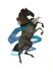
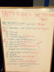
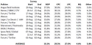
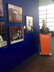
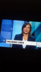
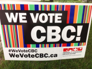

In [ ]:
# =========================
# (11) CASE ANALYSIS (giống 0.83, bỏ Macro-F1)
# =========================
from IPython.display import HTML, display
import html, io, base64

id2name      = {0: "positive", 1: "neutral", 2: "negative"}
id2name_cap  = {0: "Positive", 1: "Neutral", 2: "Negative"}
id2abbr      = {0: "P", 1: "NT", 2: "NG"}

def _mark(pred_id, true_id):
    return f"{id2abbr[int(pred_id)]} " + ("(✓)" if int(pred_id) == int(true_id) else "(×)")

def _short_text(s, n=90):
    s = (s or "").replace("\n", " ").strip()
    return (s[:n] + "…") if len(s) > n else s

def _thumb_b64(path, size=(92, 72)):
    try:
        im = Image.open(path).convert("RGB")
        im.thumbnail(size)
    except Exception:
        im = Image.new("RGB", size, (220, 220, 220))
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")


@torch.no_grad()
def _predict_full(model, loader, device):
    """CLARA full: Co-Attn + Verification + Feedback."""
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg    = _final_logits_with_feedback(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_verification(model, loader, device):
    """Bỏ Verification: dùng Prediction head trực tiếp, vẫn có Co-Attn."""
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        fused = model.fusion(v_feat, t_feat)
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_wo_feedback(model, loader, device):
    """
    Bỏ feedback loop: trong kiến trúc hiện tại tương đương dùng Prediction head trực tiếp.
    (Giống w/o_verification về mặt logits).
    """
    return _predict_wo_verification(model, loader, device)


@torch.no_grad()
def _predict_wo_coattn(model, loader, device):
    """Không dùng Co-Attn: chỉ cộng hai projection vision/text."""
    model.eval()
    P = []
    for b in loader:
        pv  = b['pixel_values'].to(device, non_blocking=True)
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        v_feat, t_feat = _forward_feats(model, pv, ids, m)
        v_h = model.fusion.v_proj(v_feat)
        t_h = model.fusion.t_proj(t_feat)
        fused = F.layer_norm(0.5 * (v_h + t_h), (v_h.shape[-1],))
        lg    = _pred_head_logits(model, fused)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_text_only(model, loader, device):
    """Chỉ dùng text branch → project text → Prediction head."""
    model.eval()
    P = []
    for b in loader:
        ids = b['input_ids'].to(device, non_blocking=True)
        m   = b['attention_mask'].to(device, non_blocking=True)
        t_out = model.text(input_ids=ids, attention_mask=m)
        t_seq = t_out.last_hidden_state
        mask  = m.unsqueeze(-1).float()
        t_feat = (t_seq * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)
        h = model.fusion.t_proj(t_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


@torch.no_grad()
def _predict_vision_only(model, loader, device):
    """Chỉ dùng vision branch → project vision → Prediction head."""
    model.eval()
    P = []
    for b in loader:
        pv = b['pixel_values'].to(device, non_blocking=True)
        v_out = model.vision(pixel_values=pv)
        v_feat = v_out.last_hidden_state.mean(dim=1)
        h = model.fusion.v_proj(v_feat)
        lg = _pred_head_logits(model, h)
        P.extend(lg.argmax(-1).cpu().numpy().tolist())
    return np.array(P, dtype=np.int64)


# y_true lấy từ evaluate() trước đó trên TEST
y_true_np = np.array(te_Y, dtype=np.int64)

# Lấy prediction của từng variant
pred_wo_ver = _predict_wo_verification(model, test_loader, device)
pred_wo_fb  = _predict_wo_feedback(model,     test_loader, device)
pred_wo_ca  = _predict_wo_coattn(model,      test_loader, device)
pred_text   = _predict_text_only(model,      test_loader, device)
pred_vision = _predict_vision_only(model,    test_loader, device)
pred_ours   = _predict_full(model,           test_loader, device)


def _pick_indices_weighted_random(y_true, pred_ours, others_preds, k=6, alpha=2.0):
    """
    Chọn các case mà:
      - CLARA (Ours) dự đoán đúng
      - Các biến thể khác dự đoán sai càng nhiều càng ưu tiên

    alpha càng lớn → càng ưu tiên case mà các variant khác sai nhiều.
    """
    idx_correct = np.where(pred_ours == y_true)[0]
    if len(idx_correct) == 0:
        return []
    others = np.stack(others_preds, axis=0)   # [num_variants, N]
    y = y_true[None, :]                       # [1, N]
    wrong_mat = (others != y)                 # [num_variants, N]
    wrong_count = wrong_mat[:, idx_correct].sum(axis=0).astype(float)  # [num_correct]

    eps = 1e-6
    weights = (wrong_count + eps) ** alpha
    weights = weights / weights.sum()

    size = min(k, len(idx_correct))
    chosen = np.random.choice(idx_correct, size=size, replace=False, p=weights)
    return chosen.tolist()


others_list = [pred_wo_ver, pred_wo_fb, pred_wo_ca, pred_text, pred_vision]
sample_indices = _pick_indices_weighted_random(
    y_true_np, pred_ours, others_list, k=6, alpha=2.0
)


def render_case_table(indices, title="Case analysis of CLARA variants (MVSA-Multiple)"):
    if len(indices) == 0:
        print("Không tìm thấy mẫu phù hợp. Hãy tăng k hoặc nới điều kiện.")
        return

    head_cols = [
        "Sample", "Text", "Image", "True",
        "w/o Verification", "w/o Feedback", "w/o Co-Attention",
        "Text-only", "Image-only", "CLARA (Ours)"
    ]
    thead = "".join([
        f'<th style="padding:8px; border:1px solid #eee; text-align:center;">{c}</th>'
        for c in head_cols
    ])

    rows_html = []
    for idx_k, i in enumerate(indices):
        s = test_samples[i]
        text_short = html.escape(_short_text(s.text, 90))

        if s.image_path and os.path.exists(s.image_path):
            img_b64 = _thumb_b64(s.image_path)
            img_tag = f'<img src="{img_b64}" style="border-radius:6px;border:1px solid #ddd;">'
        else:
            img_tag = (
                '<div style="width:92px;height:72px;'
                'border:1px dashed #ccc;border-radius:6px;'
                'background:#fafafa;"></div>'
            )

        true_name = id2name_cap[int(y_true_np[i])]

        rows_html.append(f"""
        <tr>
          <td style="text-align:center;">({chr(ord('a')+idx_k)})</td>
          <td style="vertical-align:middle; width:30%;">{text_short}</td>
          <td style="text-align:center;">{img_tag}</td>
          <td style="text-align:center;">{true_name}</td>
          <td style="text-align:center;">{_mark(pred_wo_ver[i],  y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_fb[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_wo_ca[i],   y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_text[i],    y_true_np[i])}</td>
          <td style="text-align:center;">{_mark(pred_vision[i],  y_true_np[i])}</td>
          <td style="text-align:center; font-weight:600;">{_mark(pred_ours[i],   y_true_np[i])}</td>
        </tr>
        """)

    # Dataset-wide metrics (Acc + F1-Weighted, không dùng Macro-F1)
    metrics_lines = []
    for name, P in {
        "w/o Verification": pred_wo_ver,
        "w/o Feedback":     pred_wo_fb,
        "w/o Co-Attention": pred_wo_ca,
        "Text-only":        pred_text,
        "Image-only":       pred_vision,
        "CLARA (Ours)":     pred_ours
    }.items():
        acc = accuracy_score(y_true_np, P)
        f1w = f1_score(y_true_np, P, average='weighted')
        metrics_lines.append(f"{name}: Acc={acc:.4f} | F1-Weighted={f1w:.4f}")

    metrics_html = "<br>".join(metrics_lines)

    html_table = f"""
    <div style="margin:8px 0;">
      <h4 style="margin:6px 0;">{html.escape(title)}</h4>
      <table style="width:100%; border-collapse:collapse; font-family:Arial, sans-serif; font-size:14px;">
        <thead><tr style="background:#f7f7f7;">{thead}</tr></thead>
        <tbody>{''.join(rows_html)}</tbody>
      </table>
      <div style="font-size:12px; color:#666; margin-top:6px;">
        *P = Positive, NT = Neutral, NG = Negative
      </div>
      <div style="font-size:13px; color:#444; margin-top:10px;">
        <b>Dataset-wide metrics</b><br>{metrics_html}
      </div>
    </div>
    """
    display(HTML(html_table))


# Gọi hàm để hiển thị bảng case analysis
render_case_table(sample_indices)


In [ ]:
# =========================
# Run ABLATION trên TEST
# =========================
abl_rows = []
for name, key in [
    ("Full",             "full"),
    ("w/o Verification", "w/o_verification"),
    ("w/o Feedback",     "w/o_feedback"),
    ("w/o Co-Attention", "w/o_coattn"),
    ("Text-only",        "text_only"),
    ("Vision-only",      "vision_only"),
]:
    acc, f1w = evaluate_variant(model, test_loader, device, variant=key)
    abl_rows.append({"Variant": name, "Acc": acc, "F1-Weighted": f1w})

abl_df = pd.DataFrame(abl_rows)
best_idx_abl = abl_df['F1-Weighted'].idxmax()

print("\n" + "="*66)
print("ABLATION STUDY (evaluation-only, TEST set)")
print("="*66)

# Board with pandas Styler
def _style_abl(df, best_idx):

    sty = (
        df.copy()
        .style
        .hide(axis="index")
        .format({"Acc": "{:.4f}", "F1-Weighted": "{:.4f}"})
        .set_properties(**{
            "text-align": "center",
            "padding": "6px",
            "border": "1px solid #eee",
        })
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center"),
                                         ("padding", "6px"),
                                         ("border", "1px solid #eee"),
                                         ("background-color", "#f7f7f7")]},
            {"selector": "tbody tr:nth-child(even)",
             "props": [("background-color", "#fafafa")]},
        ])
        .background_gradient(subset=["F1-Weighted"], cmap="Blues")
    )
    # highlight hàng tốt nhất
    def _highlight_best(row):
        color = "#e99935" if row.name == best_idx else ""
        return ["background-color: {}".format(color) if col == "F1-Weighted" else ""
                for col in row.index]
    sty = sty.apply(_highlight_best, axis=1)
    return sty

display(_style_abl(abl_df, best_idx_abl))

print("\n🏆 Best variant by F1-Weighted:")
print(
    abl_df.loc[[best_idx_abl]].to_string(
        index=False,
        formatters={
            "Acc": lambda x: f"{x:.4f}",
            "F1-Weighted": lambda x: f"{x:.4f}",
        },
    )
)



ABLATION STUDY (evaluation-only, TEST set)


Variant,Acc,F1-Weighted
Full,0.7351,0.7345
w/o Verification,0.7351,0.7342
w/o Feedback,0.7351,0.7342
w/o Co-Attention,0.2015,0.2024
Text-only,0.3228,0.1783
Vision-only,0.2631,0.1764



🏆 Best variant by F1-Weighted:
Variant    Acc F1-Weighted
   Full 0.7351      0.7345
